# PML setup + tuning (combined notebook)

This notebook combines two purposes:

1) **PML setup sanity**
- Verify PML thickness, sigma profiles, and geometry overlays.

2) **PML tuning**
- Compare Dirichlet vs PML.
- Compute quantitative metrics.
- Sweep PML strength and thickness with guardrails.

## Why guardrails?
It's possible to get extremely tiny reflection/leakage numbers by over-damping (or mis-scaling)
so that waves don't propagate. We therefore measure both:
- absorption quality (`iface/core`, leakage)
- propagation sanity (radial profile away from source)


In [1]:
from __future__ import annotations

import numpy as np
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

from core.config import HelmholtzConfig, PMLConfig
from core.resolution import grid_from_ppw
from core.cases import make_default_cases
from core.medium import build_medium

from operators.assemble import assemble_helmholtz_matrix
from operators.pml import build_pml_profiles

from diagnostics import (
    plot_pml_bounds,
    plot_sigma_map,
    plot_solution_with_pml,
    plot_field,
    reflection_metrics,
    pml_leakage_proxy,
)

print("Imports OK")


Imports OK


## 1) Baseline PDE parameters

We keep these fixed while tuning PML.


In [2]:
omega = 32.0
ppw_target = 10.0
lx, ly = 1.0, 1.0
n_min = 501
make_odd = True
c_min_for_grid = 1.0

case_name = "const"

# Gaussian RHS
gauss_sigma = 0.05
gauss_amp = 1.0

# Initial PML guess
npml0 = 30
m0 = 3
eta0 = 10.0          # eta := sigma_max / omega
strength0 = eta0 * omega

print("Baseline parameters set.")


Baseline parameters set.


## 2) Grid, case resolution, and medium

In [ ]:
grid = grid_from_ppw(
    omega=omega,
    ppw=ppw_target,
    lx=lx,
    ly=ly,
    c_min=c_min_for_grid,
    n_min=n_min,
    make_odd=make_odd,
)

cases = make_default_cases()
if hasattr(cases, "keys"):
    if case_name not in cases:
        raise KeyError(f"case_name={case_name} not found. Available: {list(cases.keys())}")
    case_cfg = cases[case_name]
else:
    case_cfg = next(cc for cc in cases if getattr(cc, "name", None) == case_name)

X, Y = grid.mesh()

cfg_dir = HelmholtzConfig(omega=omega, grid=grid, pml=None)
c = build_medium(cfg_dir, case_cfg, X, Y)

print(f"Grid: {grid.nx} x {grid.ny}, hx={grid.hx:.4g}")
print("min(c) =", float(np.min(c)), "max(c) =", float(np.max(c)))


ImportError: cannot import name 'grid_from_ppw' from partially initialized module 'core.resolution' (most likely due to a circular import) (C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\src\core\resolution.py)

## 3) RHS (robust Gaussian)

We intentionally use a simple Gaussian source for PML tuning.


In [4]:
x0 = 0.5 * lx
y0 = 0.5 * ly

g = gauss_amp * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * gauss_sigma**2))
f = g.reshape(-1)

print("RHS built:", f.shape)


RHS built: (251001,)


## 4) PML profile sanity check (no PDE solve)

We verify:
- geometry
- sigma ramps
- complex stretching magnitudes


npml*h = 0.06
max sigma = 320.0
max Im(s) = 10.0


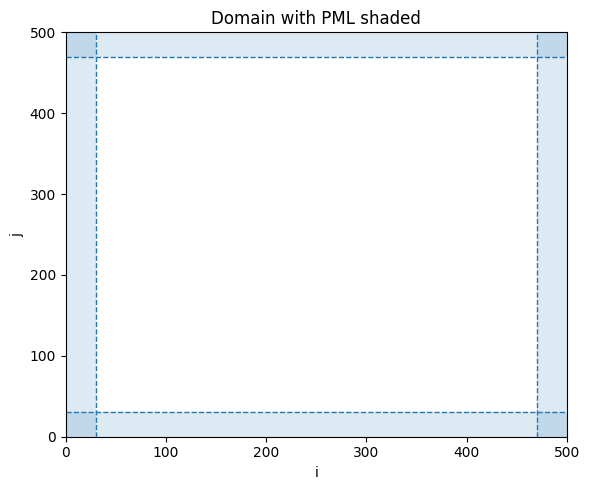

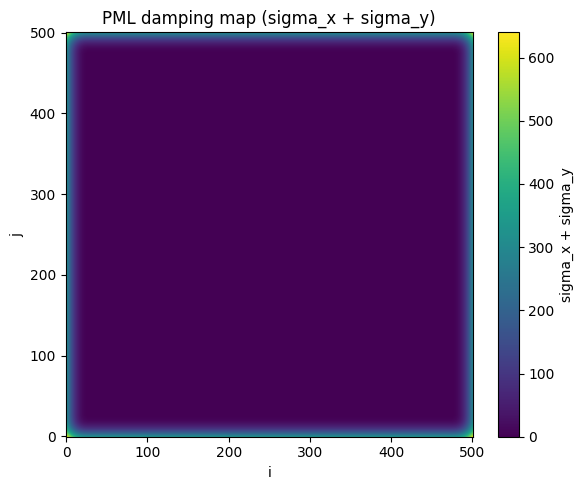

In [5]:
cfg_pml0 = HelmholtzConfig(
    omega=omega,
    grid=grid,
    pml=PMLConfig(thickness=npml0, power=m0, strength=strength0),
)

sig_x, sig_y, sx, sy = build_pml_profiles(cfg_pml0, c_ref=float(np.min(c)))

print("npml*h =", npml0 * grid.hx)
print("max sigma =", max(sig_x.max(), sig_y.max()))
print("max Im(s) =", max(np.max(np.imag(sx)), np.max(np.imag(sy))))

plot_pml_bounds(cfg_pml0, show=True)
plot_sigma_map(cfg_pml0, sig_x, sig_y, show=True)


## 5) Dirichlet vs PML comparison

This is the most important validation step.


||u_dir||2 = 0.3026540148553955
||u_pml||2 = 0.18985960112865247


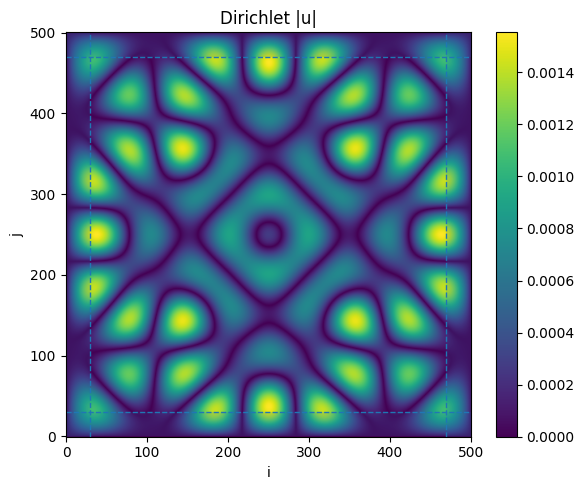

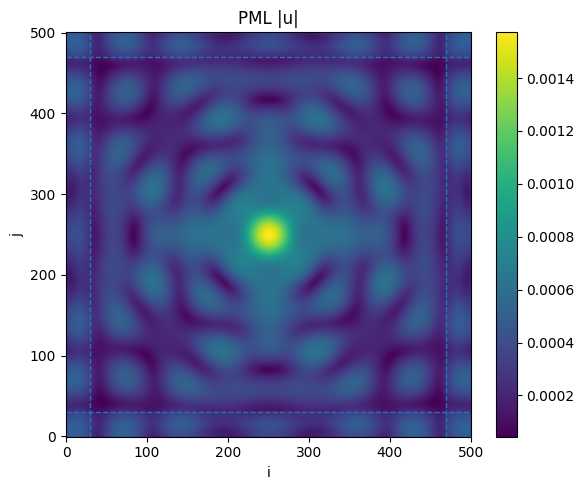

In [6]:
# Dirichlet solve
A_dir = assemble_helmholtz_matrix(cfg_dir, c)
u_dir = spla.spsolve(A_dir, f)
U_dir = u_dir.reshape(grid.nx, grid.ny)

# PML solve
A_pml = assemble_helmholtz_matrix(cfg_pml0, c)
u_pml = spla.spsolve(A_pml, f)
U_pml = u_pml.reshape(grid.nx, grid.ny)

print("||u_dir||2 =", np.linalg.norm(u_dir))
print("||u_pml||2 =", np.linalg.norm(u_pml))

plot_solution_with_pml(cfg_pml0, u_dir, title="Dirichlet |u|", show=True)
plot_solution_with_pml(cfg_pml0, u_pml, title="PML |u|", show=True)


## 6) Quantitative metrics

In [8]:
met_dir = reflection_metrics(U_dir, npml=npml0, band=5)
met_pml = reflection_metrics(U_pml, npml=npml0, band=5)

leak_dir = pml_leakage_proxy(cfg_dir, u_dir)
leak_pml = pml_leakage_proxy(cfg_pml0, u_pml)

print("Dirichlet metrics:", met_dir, "leakage:", leak_dir)
print("PML metrics:", met_pml, "leakage:", leak_pml)


Dirichlet metrics: {'core_max': 0.0015533727096941324, 'iface_max': 0.0015408581379841911, 'iface/core': 0.9919436129958807} leakage: 0.0
PML metrics: {'core_max': 0.001572695014600001, 'iface_max': 0.00029476851470047527, 'iface/core': 0.18742891149512494} leakage: 0.0002868291476326495


## 7) Propagation sanity check (radial profile)

This prevents selecting over-damped PML settings.


In [9]:
def radial_profile_abs(U, i0, j0, radii, dr=2):
    I, J = np.indices(U.shape)
    R = np.sqrt((I - i0)**2 + (J - j0)**2)
    prof = []
    for r in radii:
        mask = (R >= r-dr) & (R <= r+dr)
        prof.append(np.mean(np.abs(U[mask])))
    return np.array(prof)

i0 = grid.nx // 2
j0 = grid.ny // 2
radii = [10, 30, 60, 100, 150, 200]

p_dir = radial_profile_abs(U_dir, i0, j0, radii)
p_pml = radial_profile_abs(U_pml, i0, j0, radii)

print("r, |u| Dirichlet:", list(zip(radii, p_dir)))
print("r, |u| PML:", list(zip(radii, p_pml)))


r, |u| Dirichlet: [(10, np.float64(0.00015146351327910952)), (30, np.float64(0.0005121777680710959)), (60, np.float64(0.000551065701547997)), (100, np.float64(0.000508057142028315)), (150, np.float64(0.0005149660170321598)), (200, np.float64(0.0006914798966080446))]
r, |u| PML: [(10, np.float64(0.001457131577056001)), (30, np.float64(0.0008578645726192116)), (60, np.float64(0.0006142290815684769)), (100, np.float64(0.00046834976851889274)), (150, np.float64(0.00040793641977519656)), (200, np.float64(0.00034656683500445965))]


## Extra sanity check

In [12]:
npml = cfg_pml0.pml.thickness  # or getattr(cfg_pml0.pml, "npml", cfg_pml0.pml.thickness)

print("max sigma_x interior:", np.max(sig_x[npml:-npml]))
print("max sigma_y interior:", np.max(sig_y[npml:-npml]))
print("max |sx-1| interior:", np.max(np.abs(sx[npml:-npml] - 1)))
print("max |sy-1| interior:", np.max(np.abs(sy[npml:-npml] - 1)))


max sigma_x interior: 0.0
max sigma_y interior: 0.0
max |sx-1| interior: 0.0
max |sy-1| interior: 0.0


## 8) Strength sweep with guardrails

In [11]:
etas = [1, 2, 5, 10, 20, 40]
results = []

for eta in etas:
    strength = eta * omega
    cfg_s = HelmholtzConfig(
        omega=omega,
        grid=grid,
        pml=PMLConfig(thickness=npml0, power=m0, strength=strength),
    )

    A_s = assemble_helmholtz_matrix(cfg_s, c)
    u_s = spla.spsolve(A_s, f)
    U_s = u_s.reshape(grid.nx, grid.ny)

    met = reflection_metrics(U_s, npml=npml0, band=5)
    leak = pml_leakage_proxy(cfg_s, u_s)

    p_mid = radial_profile_abs(U_s, i0, j0, [100])[0]

    results.append((eta, met["iface/core"], leak, p_mid))

print("eta, iface/core, leakage, mid-radius |u|")
for r in results:
    print(r)


eta, iface/core, leakage, mid-radius |u|
(1, 0.5053732806287694, 0.0010437128861256373, np.float64(0.0009583467368647874))
(2, 0.35942435229395114, 0.000589345352858516, np.float64(0.0005901026858103089))
(5, 0.189122632243712, 0.00035099619089941933, np.float64(0.0004734863932337901))
(10, 0.18742891149512494, 0.0002868291476326495, np.float64(0.00046834976851889274))
(20, 0.30873336523986866, 0.0002408671645259719, np.float64(0.00043935721618645467))
(40, 0.44932277404439586, 0.00019938591694256948, np.float64(0.00039090004352310473))


## 9) Conclusion

Select PML settings that:
- strongly reduce `iface/core`
- keep `mid-radius |u|` non-negligible
- do not explode the residual

The chosen `(npml, m, eta)` becomes the **fixed PML** for dataset generation.


### Extra check 1) Narrow η sweep around the sweet spot (and pick η*)

In [13]:
etas_fine = [3, 4, 5, 6, 8, 10, 12, 15]
results_fine = []

for eta in etas_fine:
    strength = eta * omega
    cfg_s = HelmholtzConfig(
        omega=omega,
        grid=grid,
        pml=PMLConfig(thickness=npml0, power=m0, strength=float(strength)),
    )
    A_s = assemble_helmholtz_matrix(cfg_s, c)
    u_s = spla.spsolve(A_s, f)
    U_s = u_s.reshape(grid.nx, grid.ny)

    met = reflection_metrics(U_s, npml=npml0, band=5)
    leak = pml_leakage_proxy(cfg_s, u_s)
    p_mid = radial_profile_abs(U_s, i0, j0, [100])[0]

    results_fine.append((eta, met["iface/core"], leak, p_mid))

print("eta, iface/core, leakage, mid-radius |u|")
for r in results_fine:
    print(r)


eta, iface/core, leakage, mid-radius |u|
(3, 0.27006015496111346, 0.0004478067462995182, np.float64(0.0005042878363257407))
(4, 0.2190135336578797, 0.00038495984845004333, np.float64(0.0004800443722081553))
(5, 0.189122632243712, 0.00035099619089941933, np.float64(0.0004734863932337901))
(6, 0.17072839164797912, 0.0003298289296835119, np.float64(0.00047206754038904943))
(8, 0.17153925588999366, 0.00030374557137951696, np.float64(0.0004711630697908882))
(10, 0.18742891149512494, 0.0002868291476326495, np.float64(0.00046834976851889274))
(12, 0.2043412208988674, 0.0002741022500997651, np.float64(0.00046367793764937303))
(15, 0.24881593047464043, 0.00025928465739805747, np.float64(0.0004549131782345139))


### 2) Sweep npml (thickness) with η fixed (this is the big lever)

Once you choose η*, fix it and sweep thickness:

In [14]:
eta_star = 10
strength_star = eta_star * omega

npml_list = [15, 20, 25, 30, 40, 50]
results_npml = []

for npml in npml_list:
    cfg_s = HelmholtzConfig(
        omega=omega,
        grid=grid,
        pml=PMLConfig(thickness=int(npml), power=m0, strength=float(strength_star)),
    )
    A_s = assemble_helmholtz_matrix(cfg_s, c)
    u_s = spla.spsolve(A_s, f)
    U_s = u_s.reshape(grid.nx, grid.ny)

    met = reflection_metrics(U_s, npml=int(npml), band=5)
    leak = pml_leakage_proxy(cfg_s, u_s)
    p_mid = radial_profile_abs(U_s, i0, j0, [100])[0]

    results_npml.append((npml, met["iface/core"], leak, p_mid))

print("npml, iface/core, leakage, mid-radius |u|")
for r in results_npml:
    print(r)


npml, iface/core, leakage, mid-radius |u|
(15, 0.5148703796583461, 0.0008312094147705638, np.float64(0.0007140868994009919))
(20, 0.289019316309947, 0.0005019697455136553, np.float64(0.0005345103895523154))
(25, 0.20843539717234075, 0.0003722628677397015, np.float64(0.0005046771033774642))
(30, 0.18742891149512494, 0.0002868291476326495, np.float64(0.00046834976851889274))
(40, 0.18170700509356086, 0.0001920720531972638, np.float64(0.00037358464512151995))
(50, 0.17736573838781872, 0.000157540344343608, np.float64(0.0003123848938061846))


### 3) Try m ∈ {2,3,4} (impedance mismatch control)

Keep (η*, npml*) fixed, vary polynomial order:

In [15]:
npml_star = 40  # update after step 2
m_list = [2, 3, 4]
results_m = []

for m in m_list:
    cfg_s = HelmholtzConfig(
        omega=omega,
        grid=grid,
        pml=PMLConfig(thickness=int(npml_star), power=int(m), strength=float(strength_star)),
    )
    A_s = assemble_helmholtz_matrix(cfg_s, c)
    u_s = spla.spsolve(A_s, f)
    U_s = u_s.reshape(grid.nx, grid.ny)

    met = reflection_metrics(U_s, npml=int(npml_star), band=5)
    leak = pml_leakage_proxy(cfg_s, u_s)
    p_mid = radial_profile_abs(U_s, i0, j0, [100])[0]

    results_m.append((m, met["iface/core"], leak, p_mid))

print("m, iface/core, leakage, mid-radius |u|")
for r in results_m:
    print(r)


m, iface/core, leakage, mid-radius |u|
(2, 0.22378506273761523, 0.0001585449780549115, np.float64(0.00030662806933340586))
(3, 0.18170700509356086, 0.0001920720531972638, np.float64(0.00037358464512151995))
(4, 0.19101606344553218, 0.00023252265480066807, np.float64(0.0004306942086257992))


### 4) Robustness check: randomize the RHS location (avoid “tuned to center”)

This is important before declaring the PML “done”.

In [19]:
# --- RHS helper utilities (not part of solver core) ---

rng = np.random.default_rng(0)  # reproducible randomness

def sample_source_location(lx, ly, margin):
    """
    Sample a random (x0, y0) inside the domain,
    keeping at least `margin` distance from boundaries.
    """
    x0 = rng.uniform(margin, lx - margin)
    y0 = rng.uniform(margin, ly - margin)
    return x0, y0


def gaussian_rhs(X, Y, x0, y0, sigma=0.05, amp=1.0):
    """
    Build a Gaussian RHS centered at (x0, y0).
    Returns a flattened vector compatible with the solver.
    """
    g = amp * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))
    return g.reshape(-1)


In [18]:
eta_star = 10
strength_star = eta_star * omega
npml_star = 40
m_star = 3

cfg_best = HelmholtzConfig(
    omega=omega,
    grid=grid,
    pml=PMLConfig(thickness=int(npml_star), power=int(m_star), strength=float(strength_star)),
)

margin = 0.25 * lx  # keep sources well away from boundaries
n_trials = 6
trial_results = []

for t in range(n_trials):
    x0, y0 = sample_source_location(lx, ly, margin)
    f_t = gaussian_rhs(X, Y, x0, y0, sigma=gauss_sigma, amp=gauss_amp)

    A_t = assemble_helmholtz_matrix(cfg_best, c)
    u_t = spla.spsolve(A_t, f_t)
    U_t = u_t.reshape(grid.nx, grid.ny)

    met = reflection_metrics(U_t, npml=int(npml_star), band=5)
    leak = pml_leakage_proxy(cfg_best, u_t)

    trial_results.append((t, x0, y0, met["iface/core"], leak))

print("t, x0, y0, iface/core, leakage")
for r in trial_results:
    print(r)


t, x0, y0, iface/core, leakage
(0, 0.5684808436607272, 0.38489335688193516, 0.2157735844059507, 0.00019136610020732277)
(1, 0.27048676196809734, 0.25826381776426455, 0.25522811283351005, 0.0002190911192805467)
(2, 0.6566351196001362, 0.7063777886388609, 0.25612186864833403, 0.0002078667059500566)
(3, 0.5533178878835899, 0.6147482804919993, 0.21179349208746398, 0.0001950503317972465)
(4, 0.5218124957327115, 0.7175362118938842, 0.26835621331012716, 0.00019506882981885782)
(5, 0.6579267770607661, 0.25136925008507405, 0.2632369362057983, 0.0002353220112722533)


### 5) One “final report” cell: choose and print the recommended settings

After you pick (npml*, m*, η*):

In [20]:
print("=== RECOMMENDED PML SETTINGS ===")
print("omega =", omega)
print("npml  =", npml_star)
print("m     =", m_star)
print("eta   =", eta_star, "  (strength = eta*omega)")
print("strength =", strength_star)
print("===============================")


=== RECOMMENDED PML SETTINGS ===
omega = 32.0
npml  = 40
m     = 3
eta   = 10   (strength = eta*omega)
strength = 320.0


### 6) Add one definitive visualization cell (Dirichlet vs Best PML)

Keep this as your “I trust it” picture:

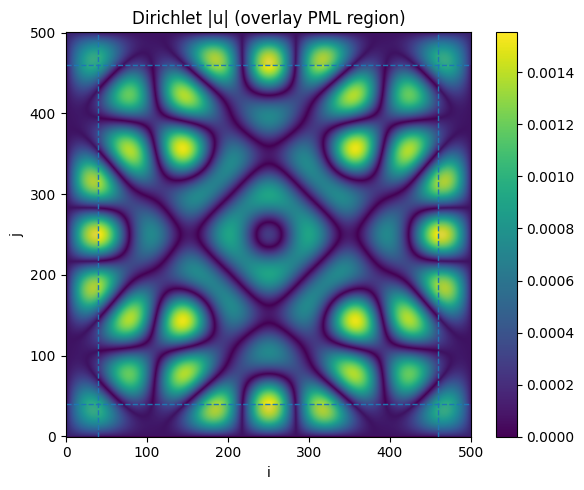

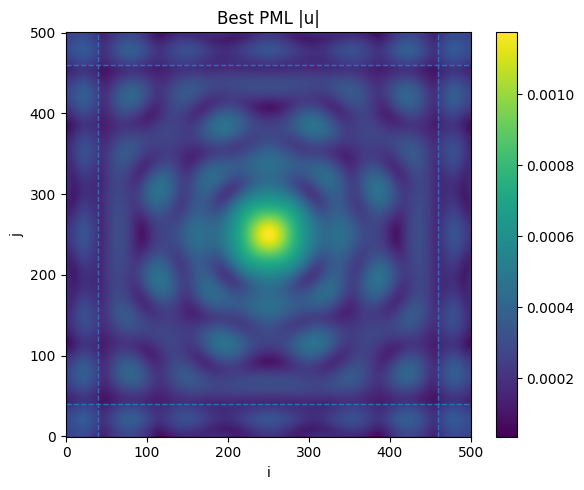

Dirichlet metrics: {'core_max': 0.001503705471036609, 'iface_max': 0.0015415382902149697, 'iface/core': 1.0251597270250368}
Best PML metrics: {'core_max': 0.0011752192578690448, 'iface_max': 0.00021354557167584305, 'iface/core': 0.18170700509356086}
Best PML leakage: 0.0001920720531972638


In [21]:
# Dirichlet solve
A_dir = assemble_helmholtz_matrix(cfg_dir, c)
u_dir = spla.spsolve(A_dir, f)
U_dir = u_dir.reshape(grid.nx, grid.ny)

# Best PML solve
A_best = assemble_helmholtz_matrix(cfg_best, c)
u_best = spla.spsolve(A_best, f)
U_best = u_best.reshape(grid.nx, grid.ny)

plot_solution_with_pml(cfg_best, u_dir, title="Dirichlet |u| (overlay PML region)", show=True)
plot_solution_with_pml(cfg_best, u_best, title="Best PML |u|", show=True)

print("Dirichlet metrics:", reflection_metrics(U_dir, npml=int(npml_star), band=5))
print("Best PML metrics:", reflection_metrics(U_best, npml=int(npml_star), band=5))
print("Best PML leakage:", pml_leakage_proxy(cfg_best, u_best))
